<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/05_fine%20tuning%20in%20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 45.0 MB/s 
     |████████████████████████████████| 197 kB 69.2 MB/s 
     |████████████████████████████████| 1.2 MB 57.5 MB/s 
     |████████████████████████████████| 60 kB 8.6 MB/s 
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *

# Can you classify the wildlife species that appear in camera trap images collected by conservation researchers?

In this challenge, we will take a look at object classification for wildlife species. Classifying wildlife is an important step to sort through images, quantify observations, and quickly find those with individual species.


Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. That's where machine learning can help! Advances in computer vision can help automate tasks like species detection and identification, so that humans can spend more time learning from and protecting these ecologies.

This post walks through an initial approach for the Conservision Practice Area challenge on DrivenData, a practice competition where you identify animal species in a real world dataset of wildlife images from Tai National Park in Côte d'Ivoire. This is a practice competition designed to be accessible to participants at all levels. That makes it a great place to dive into the world of data science competitions and computer vision.

# Baseline Model

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_features = pd.read_csv("drive/MyDrive/wildlife/train_features/train_features.csv", index_col="id")
#test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("drive/MyDrive/wildlife/train_features/train_labels.csv", index_col="id")

In [8]:
!ls

drive  gdrive  sample_data


In [9]:
os.getcwd() 

'/content'

In [ ]:
#!unzip 'gdrive/MyDrive/wildlife/train_features.zip' -d 'gdrive/MyDrive/wildlife/train_features'

In [11]:
species_labels = sorted(train_labels.columns.unique())

In [12]:
os.chdir('/content/drive/MyDrive/wildlife/train_features')


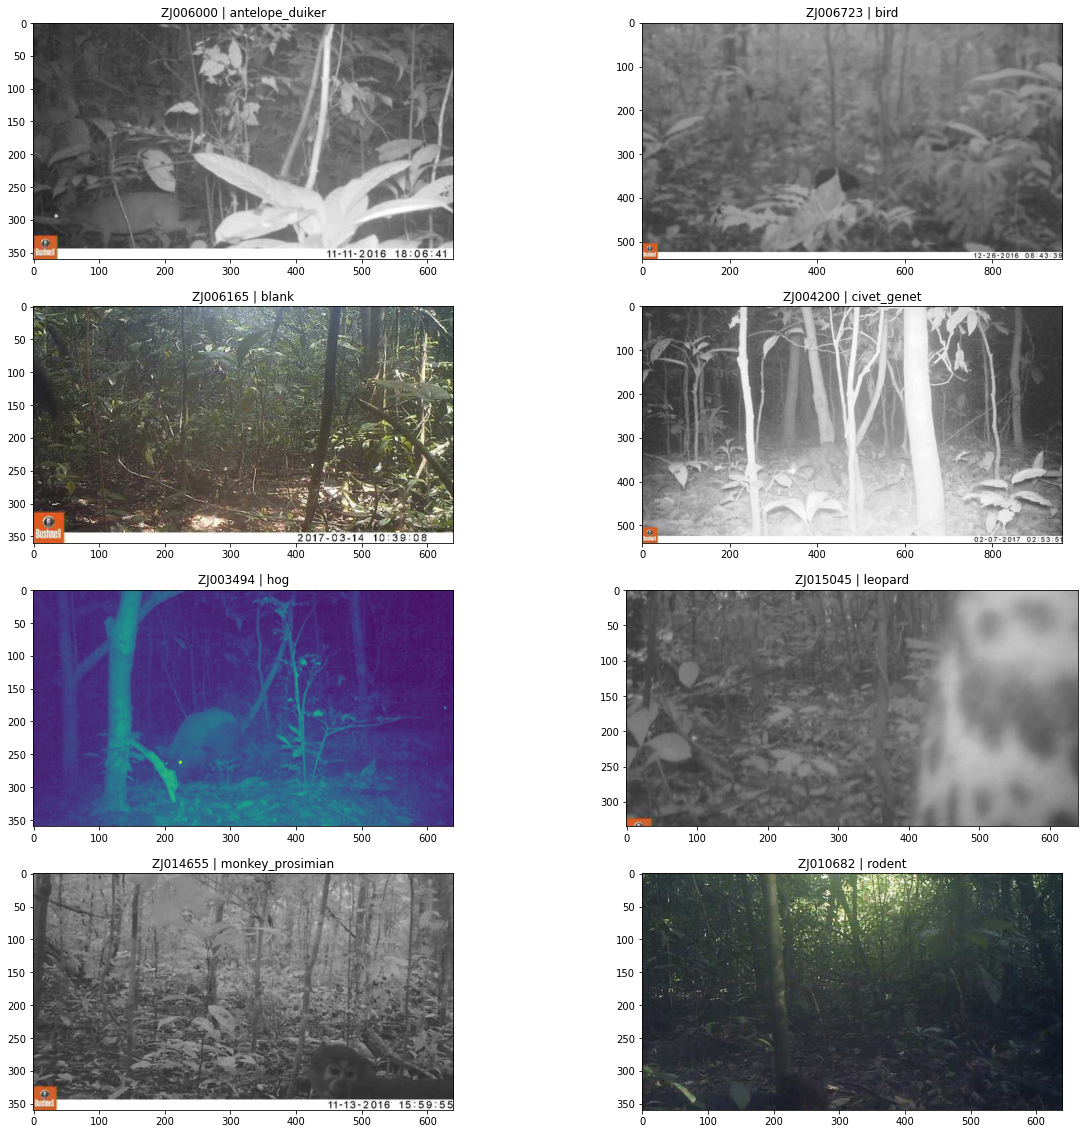

In [13]:
import matplotlib.image as mpimg

random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

In [14]:
from sklearn.model_selection import train_test_split

frac = 0.5

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [15]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((6183, 1), (6183, 8), (2061, 1), (2061, 8))

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [17]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [18]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 5

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

In [ ]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [ ]:
torch.save(model, "model.pth")

In [ ]:
loaded_model = torch.load("model.pth")

In [ ]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [ ]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

In [ ]:
eval_true = y_eval.idxmax(axis=1)
eval_predictions = eval_preds_df.idxmax(axis=1)

In [ ]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

# Using fastai API to load, manage, train, fine tune and deploy the model

In [6]:
collection =  '/content/drive/MyDrive/wildlife/train_features/train_features'

In [13]:
#load metadata
csv_file_path = '/content/drive/MyDrive/wildlife/train_features/train_features.csv'
data_import= pd.read_csv(csv_file_path)   

In [49]:
for images in os.listdir(collection):
  newname = (data_import.loc[data_import['filepath'] == images,'id']+ '_' + data_import.loc[data_import['filepath'] == images,'label'] + '.jpg').to_string()
  os.rename(collection+'/'+images,collection+'/'+newname)

In [54]:
import re
for images in os.listdir(collection):
  os.rename(collection+'/'+images,re.findall('\d+',collection +'/'+images)[-1])

OSError: ignored

In [42]:
images = 'ZJ014550.jpg'
(data_import.loc[data_import['filepath'] == images,'id']+ '_' + data_import.loc[data_import['filepath'] == images,'label'] + '.jpg').to_string()

'14550    ZJ014550_leopard.jpg'

In [47]:
'ZJ014550.jpg' in os.listdir(collection)

True

In [ ]:
newname = (data_import.loc[data_import['filepath'] == images,'id']+ '_' + data_import.loc[data_import['filepath'] == images,'label'] + '.jpg').to_string()

In [16]:
images

'ZJ008956.jpg'

In [32]:
data_import.loc[data_import['filepath'] == images,'id']+ '_' + data_import.loc[data_import['filepath'] == images,'label']

8956    ZJ008956_bird
dtype: object

In [19]:
data_import[data_import[:,'filepath']==images,'label']

TypeError: ignored

In [ ]:
for i, filename in enumerate(os.listdir(collection)):


  
    os.rename(collection + filename, "C:/darth_vader/" + str(i) + ".jpg")

In [ ]:
for r in range(0,data_import.shape[0])
    
    os.rename("/content/drive/MyDrive/wildlife/train_features/train_features" + filename,
              "/content/drive/MyDrive/wildlife/train_features/train_features" + str(i) + ".jpg")

In [45]:
import os.path
import csv
current_directory =  '/content/drive/MyDrive/wildlife/train_features/train_features'
csv_file_path = '/content/drive/MyDrive/wildlife/train_features/train_features.csv'
with open(csv_file_path, 'r') as f:
    lines = csv.reader(f, delimiter = ',')
    for line in lines:        
        current_file_path = os.path.join(current_directory,line[1])
        renamed_file_path = os.path.join(current_directory,line[0] +'_'+ line[3]+ '.jpg')
        os.rename(current_file_path, renamed_file_path)

FileNotFoundError: ignored

In [1]:
import os
os.getcwd()


'/content'

In [ ]:
collection =  '/content/drive/MyDrive/wildlife/train_features'

In [10]:
(data_import.loc[0, 'id'] + '_' +data_import.loc[0, 'label']) 

'ZJ000000_bird'

In [51]:
for r in range(0,data_import.shape[0]):
  (data_import.loc[0, 'id'] + '_' +data_import.loc[0, 'label']) 
  current_file_path = os.path.join(current_directory,data_import.loc[0, 'filepath'])


,id,filepath,site,label
0,ZJ000000,train_features/ZJ000000.jpg,S0120,bird
1,ZJ000001,train_features/ZJ000001.jpg,S0069,monkey_prosimian
2,ZJ000002,train_features/ZJ000002.jpg,S0009,bird
3,ZJ000003,train_features/ZJ000003.jpg,S0008,monkey_prosimian
4,ZJ000004,train_features/ZJ000004.jpg,S0036,leopard
...,...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093,blank
16484,ZJ016484,train_features/ZJ016484.jpg,S0043,leopard
16485,ZJ016485,train_features/ZJ016485.jpg,S0089,civet_genet
16486,ZJ016486,train_features/ZJ016486.jpg,S0095,bird


In [46]:
current_directory =  '/content/drive/MyDrive/wildlife/train_features'
csv_file_path = '/content/drive/MyDrive/wildlife/train_features/train_features.csv'
with open(csv_file_path, 'r') as f:
    lines = csv.reader(f, delimiter = ',')

In [21]:
path = untar_data(URLs.PETS)

In [23]:
path

Path('/root/.fastai/data/oxford-iiit-pet')

## From Dogs and Cats to wild life detection

In our very first model we learned how to classify dogs versus cats. Just a few years ago this was considered a very challenging task—but today, it's far too easy! We will not be able to show you the nuances of training models with this problem, because we get a nearly perfect result without worrying about any of the details. 

We start with some dataset that we know nothing about. We then have to figure out how it is put together, how to extract the data we need from it, and what that data looks like. For the rest of this book we will be showing you how to solve these problems in practice, including all of the intermediate steps necessary to understand the data that you are working with and test your modeling as you go.

We already downloaded the Pet dataset, and we can get a path to this dataset using the same code as in <<chapter_intro>>:

In [35]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Now if we are going to understand how to extract the breed of each pet from each image we're going to need to understand how this data is laid out. Such details of data layout are a vital piece of the deep learning puzzle. Data is usually provided in one of these two ways:

- Individual files representing items of data, such as text documents or images, possibly organized into folders or with filenames representing information about those items
- A table of data, such as in CSV format, where each row is an item which may include filenames providing a connection between the data in the table and data in other formats, such as text documents and images

There are exceptions to these rules—particularly in domains such as genomics, where there can be binary database formats or even network streams—but overall the vast majority of the datasets you'll work with will use some combination of these two formats.

To see what is in our dataset we can use the `ls` method:

In [36]:
#hide
Path.BASE_PATH = path

In [37]:
path.ls()

(#2) [Path('images'),Path('annotations')]

We can see that this dataset provides us with *images* and *annotations* directories. The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the *annotations* directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the *images* directory:

In [38]:
(path/"images").ls()

(#7393) [Path('images/wheaten_terrier_15.jpg'),Path('images/english_cocker_spaniel_194.jpg'),Path('images/basset_hound_56.jpg'),Path('images/newfoundland_97.jpg'),Path('images/Bombay_171.jpg'),Path('images/great_pyrenees_12.jpg'),Path('images/wheaten_terrier_88.jpg'),Path('images/scottish_terrier_190.jpg'),Path('images/Russian_Blue_202.jpg'),Path('images/yorkshire_terrier_40.jpg')...]

Most functions and methods in fastai that return a collection use a class called `L`. `L` can be thought of as an enhanced version of the ordinary Python `list` type, with added conveniences for common operations. For instance, when we display an object of this class in a notebook it appears in the format shown there. The first thing that is shown is the number of items in the collection, prefixed with a `#`. You'll also see in the preceding output that the list is suffixed with an ellipsis. This means that only the first few items are displayed—which is a good thing, because we would not want more than 7,000 filenames on our screen!

By examining these filenames, we can see how they appear to be structured. Each filename contains the pet breed, and then an underscore (`_`), a number, and finally the file extension. We need to create a piece of code that extracts the breed from a single `Path`. Jupyter notebooks make this easy, because we can gradually build up something that works, and then use it for the entire dataset. We do have to be careful to not make too many assumptions at this point. For instance, if you look carefully you may notice that some of the pet breeds contain multiple words, so we cannot simply break at the first `_` character that we find. To allow us to test our code, let's pick out one of these filenames:

In [ ]:
fname = (path/"images").ls()[0]

The most powerful and flexible way to extract information from strings like this is to use a *regular expression*, also known as a *regex*. A regular expression is a special string, written in the regular expression language, which specifies a general rule for deciding if another string passes a test (i.e., "matches" the regular expression), and also possibly for plucking a particular part or parts out of that other string. 

In this case, we need a regular expression that extracts the pet breed from the filename.

We do not have the space to give you a complete regular expression tutorial here, but there are many excellent ones online and we know that many of you will already be familiar with this wonderful tool. If you're not, that is totally fine—this is a great opportunity for you to rectify that! We find that regular expressions are one of the most useful tools in our programming toolkit, and many of our students tell us that this is one of the things they are most excited to learn about. So head over to Google and search for "regular expressions tutorial" now, and then come back here after you've had a good look around. The [book's website](https://book.fast.ai/) also provides a list of our favorites.

> a: Not only are regular expressions dead handy, but they also have interesting roots. They are "regular" because they were originally examples of a "regular" language, the lowest rung within the Chomsky hierarchy, a grammar classification developed by linguist Noam Chomsky, who also wrote _Syntactic Structures_, the pioneering work searching for the formal grammar underlying human language. This is one of the charms of computing: it may be that the hammer you reach for every day in fact came from a spaceship.

When you are writing a regular expression, the best way to start is just to try it against one example at first. Let's use the `findall` method to try a regular expression against the filename of the `fname` object:

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequence characters are numerical digits and then the JPEG file extension.

Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the `RegexLabeller` class. In this example we use the data block API we saw in <<chapter_production>> (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in <<chapter_intro>>):

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call *presizing*. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

## Presizing

We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

To work around these challenges, presizing adopts two strategies that are shown in <<presizing>>:

1. Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions. 
1. Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="https://github.com/fastai/fastbook/blob/master/images/att_00060.png?raw=1">

This picture shows the two steps:

1. *Crop full width or height*: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
2. *Random crop and augment*: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

<<interpolations>> shows the difference between an image that has been zoomed, interpolated, rotated, and then interpolated again (which is the approach used by all other deep learning libraries), shown here on the right, and an image that has been zoomed and rotated as one operation and then interpolated just once on the left (the fastai approach), shown here on the left.

In [ ]:
Path.cwd()

In [ ]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

You can see that the image on the right is less well defined and has reflection padding artifacts in the bottom-left corner; also, the grass at the top left has disappeared entirely. We find that in practice using presizing significantly improves the accuracy of models, and often results in speedups too.

The fastai library also provides simple ways to check your data looks right before training a model, which is an extremely important step. We'll look at those next.

### Checking and Debugging a DataBlock

We can never just assume that our code is working perfectly. Writing a `DataBlock` is just like writing a blueprint. You will get an error message if you have a syntax error somewhere in your code, but you have no guarantee that your template is going to work on your data source as you intend. So, before training a model you should always check your data. You can do this using the `show_batch` method:

In [ ]:
dls.show_batch(nrows=1, ncols=3)

Take a look at each image, and check that each one seems to have the correct label for that breed of pet. Often, data scientists work with data with which they are not as familiar as domain experts may be: for instance, I actually don't know what a lot of these pet breeds are. Since I am not an expert on pet breeds, I would use Google images at this point to search for a few of these breeds, and make sure the images look similar to what I see in this output.

If you made a mistake while building your `DataBlock`, it is very likely you won't see it before this step. To debug this, we encourage you to use the `summary` method. It will attempt to create a batch from the source you give it, with a lot of details. Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help. For instance, one common mistake is to forget to use a `Resize` transform, so you end up with pictures of different sizes and are not able to batch them. Here is what the summary would look like in that case (note that the exact text may have changed since the time of writing, but it will give you an idea):

In [ ]:
#hide_output
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

You can see exactly how we gathered the data and split it, how we went from a filename to a *sample* (the tuple (image, category)), then what item transforms were applied and how it failed to collate those samples in a batch (because of the different shapes). 

Once you think your data looks right, we generally recommend the next step should be using it to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your problem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model at all. These are things that you want to know as soon as possible. For this initial test, we'll use the same simple model that we used in <<chapter_intro>>:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

Remember that *loss* is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using *cross-entropy loss*.

## Cross-Entropy Loss

*Cross-entropy loss* is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

- It works even when our dependent variable has more than two categories.
- It results in faster and more reliable training.

In order to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

### Viewing Activations and Labels

Let's take a look at the activations of our model. To actually get a batch of real data from our `DataLoaders`, we can use the `one_batch` method:

In [ ]:
x,y = dls.one_batch()

As you see, this returns the dependent and independent variables, as a mini-batch. Let's see what is actually contained in our dependent variable:

In [ ]:
y

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using `Learner.get_preds`. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable `_`:

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [ ]:
len(preds[0]),preds[0].sum()

To transform the activations of our model into predictions like this, we used something called the *softmax* activation function.

### Softmax

In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.

Softmax is similar to the sigmoid function, which we saw earlier. As a reminder sigmoid looks like this:

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

We can apply this function to a single column of activations from a neural network, and get back a column of numbers between 0 and 1, so it's a very useful activation function for our final layer.

Now think about what happens if we want to have more categories in our target (such as our 37 pet breeds). That means we'll need more activations than just a single column: we need an activation *per category*. We can create, for instance, a neural net that predicts 3s and 7s that returns two activations, one for each class—this will be a good first step toward creating the more general approach. Let's just use some random numbers with a standard deviation of 2 (so we multiply `randn` by 2) for this example, assuming we have 6 images and 2 possible categories (where the first column represents 3s and the second is 7s):

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

We can't just take the sigmoid of this directly, since we don't get rows that add to 1 (i.e., we want the probability of being a 3 plus the probability of being a 7 to add up to 1):

In [ ]:
acts.sigmoid()

In <<chapter_mnist_basics>>, our neural net created a single activation per image, which we passed through the `sigmoid` function. That single activation represented the model's confidence that the input was a 3. Binary problems are a special case of classification problems, because the target can be treated as a single boolean value, as we did in `mnist_loss`. But binary problems can also be thought of in the context of the more general group of classifiers with any number of categories: in this case, we happen to have two categories. As we saw in the bear classifier, our neural net will return one activation per category.

So in the binary case, what do those activations really indicate? A single pair of activations simply indicates the *relative* confidence of the input being a 3 versus being a 7. The overall values, whether they are both high, or both low, don't matter—all that matters is which is higher, and by how much.

We would expect that since this is just another way of representing the same problem, that we would be able to use `sigmoid` directly on the two-activation version of our neural net. And indeed we can! We can just take the *difference* between the neural net activations, because that reflects how much more sure we are of the input being a 3 than a 7, and then take the sigmoid of that:

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

The second column (the probability of it being a 7) will then just be that value subtracted from 1. Now, we need a way to do all this that also works for more than two columns. It turns out that this function, called `softmax`, is exactly that:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

> jargon: Exponential function (exp): Literally defined as `e**x`, where `e` is a special number approximately equal to 2.718. It is the inverse of the natural logarithm function. Note that `exp` is always positive, and it increases _very_ rapidly!

Let's check that `softmax` returns the same values as `sigmoid` for the first column, and those values subtracted from 1 for the second column:

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

`softmax` is the multi-category equivalent of `sigmoid`—we have to use it any time we have more than two categories and the probabilities of the categories must add to 1, and we often use it even when there are just two categories, just to make things a bit more consistent. We could create other functions that have the properties that all activations are between 0 and 1, and sum to 1; however, no other function has the same relationship to the sigmoid function, which we've seen is smooth and symmetric. Also, we'll see shortly that the softmax function works well hand-in-hand with the loss function we will look at in the next section.

If we have three output activations, such as in our bear classifier, calculating softmax for a single bear image would then look like something like <<bear_softmax>>.

<img alt="Bear softmax example" width="280" id="bear_softmax" caption="Example of softmax on the bear classifier" src="https://github.com/fastai/fastbook/blob/master/images/att_00062.png?raw=1">

What does this function do in practice? Taking the exponential ensures all our numbers are positive, and then dividing by the sum ensures we are going to have a bunch of numbers that add up to 1. The exponential also has a nice property: if one of the numbers in our activations `x` is slightly bigger than the others, the exponential will amplify this (since it grows, well... exponentially), which means that in the softmax, that number will be closer to 1. 

Intuitively, the softmax function *really* wants to pick one class among the others, so it's ideal for training a classifier when we know each picture has a definite label. (Note that it may be less ideal during inference, as you might want your model to sometimes tell you it doesn't recognize any of the classes that it has seen during training, and not pick a class because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.)

Softmax is the first part of the cross-entropy loss—the second part is log likelihood. 

### Log Likelihood

When we calculated the loss for our MNIST example in the last chapter we used:

```python
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
```

Just as we moved from sigmoid to softmax, we need to extend the loss function to work with more than just binary classification—it needs to be able to classify any number of categories (in this case, we have 37 categories). Our activations, after softmax, are between 0 and 1, and sum to 1 for each row in the batch of predictions. Our targets are integers between 0 and 36.  Furthermore, cross-entropy loss generalizes our binary classification loss and allows for more than one correct label per example (which is called multi-label classificaiton, which we will discuss in Chapter 6).

In the binary case, we used `torch.where` to select between `inputs` and `1-inputs`. When we treat a binary classification as a general classification problem with two categories, it actually becomes even easier, because (as we saw in the previous section) we now have two columns, containing the equivalent of `inputs` and `1-inputs`. Since there is only one correct label per example, all we need to do is select the appropriate column (as opposed to multiplying multiple probabilities). Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:

In [ ]:
targ = tensor([0,1,0,1,1,0])

and these are the softmax activations:

In [ ]:
sm_acts

Then for each item of `targ` we can use that to select the appropriate column of `sm_acts` using tensor indexing, like so:

In [ ]:
idx = range(6)
sm_acts[idx, targ]

To see exactly what's happening here, let's put all the columns together in a table. Here, the first two columns are our activations, then we have the targets and the row index.  We explain the last column, `result` below:

In [ ]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

Looking at this table, you can see that the `result` column can be calculated by taking the `targ` and `idx` columns as indices into the two-column matrix containing the `3` and `7` columns. That's what `sm_acts[idx, targ]` is actually doing.  The really interesting thing here is that this actually works just as well with more than two columns. To see this, consider what would happen if we added an activation column for every digit (0 through 9), and then `targ` contained a number from 0 to 9.

PyTorch provides a function that does exactly the same thing as `sm_acts[range(n), targ]` (except it takes the negative, because when applying the log afterward, we will have negative numbers), called `nll_loss` (*NLL* stands for *negative log likelihood*):

In [ ]:
-sm_acts[idx, targ]

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

Despite its name, this PyTorch function does not take the log. We'll see why in the next section, but first, let's see why taking the logarithm can be useful.

> warning: Confusing Name, Beware: The nll in `nll_loss` stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have _already_ taken the log. PyTorch has a function called `log_softmax` that combines `log` and `softmax` in a fast and accurate way. `nll_loss` is designed to be used after `log_softmax`.

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

In [ ]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

Additionally, we want to ensure our model is able to detect differences between small numbers.  For example, consider the probabilities of .01 and .001.  Indeed, those numbers are very close together—but in another sense, 0.01 is 10 times more confident than 0.001.  By taking the log of our probabilities, we prevent these important differences from being ignored.

Does "logarithm" ring a bell? The logarithm function has this identity:

```
y = b**a
a = log(y,b)
```

In this case, we're assuming that `log(y,b)` returns *log y base b*. However, PyTorch actually doesn't define `log` this way: `log` in Python uses the special number `e` (2.718...) as the base.

Perhaps a logarithm is something that you have not thought about for the last 20 years or so. But it's a mathematical idea that is going to be really critical for many things in deep learning, so now would be a great time to refresh your memory. The key thing to know about logarithms is this relationship:

    log(a*b) = log(a)+log(b)

When we see it in that format, it looks a bit boring; but think about what this really means. It means that logarithms increase linearly when the underlying signal increases exponentially or multiplicatively. This is used, for instance, in the Richter scale of earthquake severity, and the dB scale of noise levels. It's also often used on financial charts, where we want to show compound growth rates more clearly. Computer scientists love using logarithms, because it means that multiplication, which can create really really large and really really small numbers, can be replaced by addition, which is much less likely to result in scales that are difficult for our computers to handle.

Observe that the log of a number approaches negative infinity as the number approaches zero.  In our case, since the result relfects the predicted probability of the correct label, we want our loss function to return a small value when the prediction is "good" (closer to 1) and a large value when the prediction is "bad" (closer to 0).  We can achieve this by taking the negative of the log:

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

> s: It's not just computer scientists that love logs! Until computers came along, engineers and scientists used a special ruler called a "slide rule" that did multiplication by adding logarithms. Logarithms are widely used in physics, for multiplying very big or very small numbers, and many other fields.

Let's go ahead and update our previous table with an additional column, `loss` to reflect this loss function:

In [ ]:
#hide_input
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

Notice how the loss is very large in the third and fourth rows where the predictions are confident and wrong, or in other words have high probabilities on the wrong class.  One benefit of using the log to calculate the loss is that our loss function penalizes predictions that are both confident and wrong.  This kind of penalty works well in practice to aid in more effective model training.  

> s: There are other loss functions such as [focal loss](https://arxiv.org/pdf/1708.02002.pdf) that allow you control this penalty with a parameter.  We do not discuss that loss function in this book.

We're calculating the loss from the column containing the correct label. Because there is only one "right" answer per example, we don't need to consider the other columns, because by the definition of softmax, they add up to 1 minus the activation corresponding to the correct label. As long as the activation columns sum to 1 (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit.  Therefore, making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.  

### Negative Log Likelihood

Taking the mean of the negative log of our probabilities (taking the mean of the `loss` column of our table) gives us the *negative log likelihood* loss, which is another name for cross-entropy loss. Recall that PyTorch's `nll_loss` assumes that you already took the log of the softmax, so it doesn't actually do the logarithm for you.

When we first take the softmax, and then the log likelihood of that, that combination is called *cross-entropy loss*. In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`):

In [ ]:
loss_func = nn.CrossEntropyLoss()

As you see, this is a class. Instantiating it gives you an object which behaves like a function:

In [ ]:
loss_func(acts, targ)

All PyTorch loss functions are provided in two forms, the class just shown above, and also a plain functional form, available in the `F` namespace:

In [ ]:
F.cross_entropy(acts, targ)

Either one works fine and can be used in any situation. We've noticed that most people tend to use the class version, and that's more often used in PyTorch's official docs and examples, so we'll tend to use that too.

By default PyTorch loss functions take the mean of the loss of all items. You can use `reduction='none'` to disable that:

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

You will notice these values match the `loss` column in our table exactly.

> s: An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of `cross_entropy(a,b)` is just `softmax(a)-b`. Since `softmax(a)` is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by `y_range`), since the gradient of `(a-b)**2` is `2*(a-b)`. Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

We have now seen all the pieces hidden behind our loss function. But while this puts a number on how well (or badly) our model is doing, it does nothing to help us know if it's actually any good. Let's now see some ways to interpret our model's predictions.

## Model Interpretation

It's very hard to interpret loss functions directly, because they are designed to be things computers can differentiate and optimize, not things that people can understand. That's why we have metrics. These are not used in the optimization process, but just to help us poor humans understand what's going on. In this case, our accuracy is looking pretty good already! So where are we making mistakes?

We saw in <<chapter_intro>> that we can use a confusion matrix to see where our model is doing well, and where it's doing badly:

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Oh dear—in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [ ]:
interp.most_confused(min_val=5)

Since we are not pet breed experts, it is hard for us to know whether these category errors reflect actual difficulties in recognizing breeds. So again, we turn to Google. A little bit of Googling tells us that the most common category errors shown here are actually breed differences that even expert breeders sometimes disagree about. So this gives us some comfort that we are on the right track.

We seem to have a good baseline. What can we do now to make it even better?

## Improving Our Model

We will now look at a range of techniques to improve the training of our model and make it better. While doing so, we will explain a little bit more about transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the learning rate. We saw in the previous chapter that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

### The Learning Rate Finder

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

That doesn't look good. Here's what happened. The optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer!

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the *learning rate finder*. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing 

The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

We can see on this plot that in the range 1e-6 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges like the one before (you can try for yourself), but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

> Note: Logarithmic Scale: The learning rate finder plot has a logarithmic scale, which is why the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate.

It's interesting that the learning rate finder was only discovered in 2015, while neural networks have been under development since the 1950s. Throughout that time finding a good learning rate has been, perhaps, the most important and challenging issue for practitioners. The solution does not require any advanced maths, giant computing resources, huge datasets, or anything else that would make it inaccessible to any curious researcher. Furthermore, Leslie Smith, was not part of some exclusive Silicon Valley lab, but was working as a naval researcher. All of this is to say: breakthrough work in deep learning absolutely does not require access to vast resources, elite teams, or advanced mathematical ideas. There is lots of work still to be done that requires just a bit of common sense, creativity, and tenacity.

Now that we have a good learning rate to train our model, let's look at how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning

We discussed briefly in <<chapter_intro>> how transfer learning works. We saw that the basic idea is that a pretrained model, trained potentially on millions of data points (such as ImageNet), is fine-tuned for some other task. But what does this really mean?

We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. As we saw in the images from the [Zeiler and Fergus paper](https://arxiv.org/pdf/1311.2901.pdf) in <<chapter_intro>> (see <<img_layer1>> through <<img_layer4>>), the first few layers encode very general concepts, such as finding gradients and edges, and later layers encode concepts that are still very useful for us, such as finding eyeballs and fur.

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task (classify pet breeds), and only adjust them as required for the specifics of our particular task.

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called *freezing* those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the `fine_tune` method fastai does two things:

- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for the number of epochs requested

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The `fine_tune` method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior. Remember that you can see the source code for the method by using the following syntax:

    learn.fine_tune??

So let's try doing this manually ourselves. First of all we will train the randomly added layers for three epochs, using `fit_one_cycle`. As mentioned in <<chapter_intro>>, `fit_one_cycle` is the suggested way to train models without using `fine_tune`. We'll see why later in the book; in short, what `fit_one_cycle` does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.

In [ ]:
learn.fine_tune??

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

Then we'll unfreeze the model:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

In [ ]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

In addition, do you remember the images we saw in <<chapter_intro>>, showing what each layer learns? The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <<chapter_nlp>>. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds, as seen in <<yosinski>>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="https://github.com/fastai/fastbook/blob/master/images/att_00039.png?raw=1">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

### Selecting the Number of Epochs

Often you will find that you are limited by time, rather than generalization and accuracy, when choosing how many epochs to train for. So your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for. Then look at the training and validation loss plots, as shown above, and in particular your metrics, and if you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

On the other hand, you may well see that the metrics you have chosen are really getting worse at the end of training. Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as *early stopping*. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.

If you have the time to train for more epochs, you may want to instead use that time to train more parameters—that is, use a deeper architecture.

### Deeper Architectures

In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.) For most of the architectures that we will be seeing in this book, you can create larger versions of them by simply adding more layers. However, since we want to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us.

This is why, in practice, architectures tend to come in a small number of variants. For instance, the ResNet architecture that we are using in this chapter comes in variants with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet. A larger (more layers and parameters; sometimes described as the "capacity" of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

You'll see here we've gone back to using `fine_tune`, since it's so handy! We can pass `freeze_epochs` to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, we're not seeing a clear win from the deeper model. This is useful to remember—bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up.

## Conclusion

In this chapter you learned some important practical tips, both for getting your image data ready for modeling (presizing, data block summary) and for fitting the model (learning rate finder, unfreezing, discriminative learning rates, setting the number of epochs, and using deeper architectures). Using these tools will help you to build more accurate image models, more quickly.

We also discussed cross-entropy loss. This part of the book is worth spending plenty of time on. You aren't likely to need to actually implement cross-entropy loss from scratch yourself in practice, but it's really important you understand the inputs to and output from that function, because it (or a variant of it, as we'll see in the next chapter) is used in nearly every classification model. So when you want to debug a model, or put a model in production, or improve the accuracy of a model, you're going to need to be able to look at its activations and loss, and understand what's going on, and why. You can't do that properly if you don't understand your loss function.

If cross-entropy loss hasn't "clicked" for you just yet, don't worry—you'll get there! First, go back to the last chapter and make sure you really understand `mnist_loss`. Then work gradually through the cells of the notebook for this chapter, where we step through each piece of cross-entropy loss. Make sure you understand what each calculation is doing, and why. Try creating some small tensors yourself and pass them into the functions, to see what they return.

Remember: the choices made in the implementation of cross-entropy loss are not the only possible choices that could have been made. Just like when we looked at regression we could choose between mean squared error and mean absolute difference (L1). If you have other ideas for possible functions that you think might work, feel free to give them a try in this chapter's notebook! (Fair warning though: you'll probably find that the model will be slower to train, and less accurate. That's because the gradient of cross-entropy loss is proportional to the difference between the activation and the target, so SGD always gets a nicely scaled step for the weights.)

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.